Earlier this spring, [Dr. Tom Jordan][tj] of USC and the [Southern 
California Earthquake Center][scec] caused a bit of a stir by claiming 
that the southern San Andreas fault was ['locked, loaded and ready to 
roll'][llr]. This was interpreted by many as meaning that an earthquake
on the fault is 'overdue', although it's not clear what 'overdue' means in 
this scientific context. 

In a general sense, 'overdue' means that an event was *expected* to have
occurred by now, [and has not yet][od]; this requires a due date for
the event. A due date for an earthquake is an earthquake prediction, which
can be made with precision proportional to B.S. content. And of course
a precise prediction for an earthquake date in the past that didn't happen is
pretty stuffed with it.

The root of the issue is that large, surface-breaking earthquakes happen
on the southern San Andreas [about every 100 years][ks], and it's been 
159 years (as of 2016) since the last event, the *M* 7.9 Fort Tejon
earthquake in 1857. So, if earthquakes occur very regularly (periodically
in the mathematical sense), an earthquake is overdue. This either means 
that the system is fundamentally changed in some sense (like the fault
stopped moving) or that disaster is imminent. But geology ain't math, 
and earthquakes are never perfectly periodic. On the other hand, if
earthquake reoccurrence is highly irregular, while we might have been
waiting a little bit longer than average for The Big One, it's often
late and this may not mean much.

What we really need to do, then, is to nail down our expectations of when
the next earthquake should occur, by looking at the recurrence intervals
(the time in between earthquakes) in the past. Then, we can adjust our
expectations of how much longer we might wait for the next earthquake
based on the fault's history.

I'm going to look at this quantitatively, using a branch of statistics
called ['survival analysis'][sa] that deals with the time to occurrence of
events. Survival analysis is probably most familiar in the form of life
expectancies (i.e. a person born in 2015 can expect to live for
[71.4 years][who]), but it's pretty common in other fields. Engineers use
the same tools and concepts for the lifecycles of products, in what is often
referred to as failure or reliability analysis. It is quite applicable in
studying earthquake recurrence, as well, although I am not sure how much
of the earthquake research community really uses the tools; I have found
some uses of the vocabulary and concepts in the hazard modeling literature,
which has a strong engineering influence, but I haven't seen a whole lot
in the paleoseismology or neotectonics literature. I'm guessing this is
because paleoseismologists and neotectonicists (myself included) are 
trained as geologists and don't receive a lot of formal statistical
training, but are smart and figure things out on their own as needed (lots of wheel reinventing here, but most of the time the wheels are round-ish and sort
of roll.)

The data I'll be using is from the Wrightwood and Pallet Creek paleoseismic
sites on the southern San Andreas Fault. (Note that Dr. Jordan may have been
referring to the *more* southern San Andreas section by the Salton Sea,
which has not had an earthquake since the late 1680s; but the best data is
from the San Andreas in between Parkfield and Palm Springs, which contains
the Wrightwood and Pallet Creek sites, and is often called the Southern 
San Andreas, and is the big dangerous one because of proximity to L.A.) I've
collected the data from [Scharer et al., 2010][ks] and [Biasi et al., 2002]
[bs], and formatted it into a [CSV file][eqcsv]. The analysis will be done right
here in this blog post, as a Jupyter Notebook, in Python. If you want to download
and execute it, fetch it [here][gist].

[sa]: https://en.wikipedia.org/wiki/Survival_analysis
[who]: http://www.who.int/gho/mortality_burden_disease/life_tables/situation_trends/en/

[tj]: https://dornsife.usc.edu/cf/faculty-and-staff/faculty.cfm?pid=1003391
[scec]: https://www.scec.org/
[llr]: http://www.latimes.com/local/lanow/la-me-ln-san-andreas-fault-earthquake-20160504-story.html
[od]: http://www.freeworldu.org/text%20passages/lbPoetry2.pdf
[ks]: http://geology.gsapubs.org/content/38/6/555.short
[bs]: http://crack.seismo.unr.edu/~glenn/ftp/pubs/biasi_et_al_2002_BSSA.pdf
[eqcsv]: https://gist.github.com/cossatot/a06479475ea8f2bfd881903fac830164
[gist]: https://gist.github.com/cossatot/b54a8a51e5b97a887c8bc9228ca8e061

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import trapz

## Wrightwood earthquake data

In [3]:
wrightwood_eqs = pd.read_csv('wrightwood_eq_times.csv')

wrightwood_eqs.head()

,eq,age_mean,age_5,age_95
0,W350,-2915,-2974,-2883
1,W380,-2746,-2807,-2695
2,W390,-2657,-2742,-2601
3,W402,-2610,-2670,-2569
4,W410,-2503,-2561,-2450


These are the years that earthquakes occurred at Wrightwood and Pallet
Creek, in Years AD. The `age_mean` column is the mean of the age PDFs from
the geochronology, and `age_5` and `age_95` columns are the 5th and 95th 
percentiles.

Here is what the data look like:

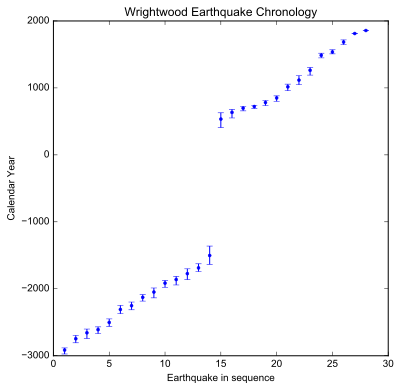

In [4]:
plt.figure(figsize=(6,6))

plt.errorbar(wrightwood_eqs.index + 1, wrightwood_eqs.age_mean,
             yerr=np.array((wrightwood_eqs.age_mean - wrightwood_eqs.age_5,
                     wrightwood_eqs.age_95 - wrightwood_eqs.age_mean)),
             fmt='.')
plt.ylabel('Calendar Year')
plt.xlabel('Earthquake in sequence')
plt.title('Wrightwood Earthquake Chronology')

plt.show()

We can see that there are basically two time series here, with a big
gap in between. This is because of a change in the locations of the 
paleoseismic trenches, which record different time periods; it's 
not a 2000-year cessation of earthquakes.

The older series looks pretty linear, meaning that earthquakes were
pretty 'periodic', or were spaced regularly in time. The younger series
is a little less linear, but also has less uncertainty. It's possible
that the greater uncertainty in the timing of older earthquakes masks
the aperiodicity that is seen in the younger series, or that
changes between the paleoseismic sites or the dating methods (and
assumptions) leads to the differences. It's also possible that there
have been real changes in the periodicity of earthquakes on the San
Andreas, captured here. (My bet is on the former.)

I'm going to calculate the recurrence interval distribution on the San Andreas
based on this data; it's a good exercise in data science and Monte
Carlo techniques, but may not be of interest to those who came to
this page solely to learn about earthquake hazards. But for those
of you who are interested, [head to the bottom third of the blog post](#Appendix:-Calculating-earthquake-recurrence-probabilities). 
(For those who want to run this post as a Jupyter notebook, that code 
will have to be run now.) For those who are not, just note that I made
a million synthetic earthquake histories drawn from the data, that
incorporates the uncertainty in the ages for each earthquake. Then,
I calculated the time between each event, and then aggregated the results.
The recurrence interval distribution has uncertainty that reflects both
the natural variability in the system (aleatoric uncertainty) and the
uncertainty involved in the dating methods themselves (epistemic uncertainty).

I split the older and younger time series apart for those calculations,
so there wasn't a 2000 year recurrence interval wreaking havoc on the stats.

Here's what the resulting recurrence interval distributions look like:

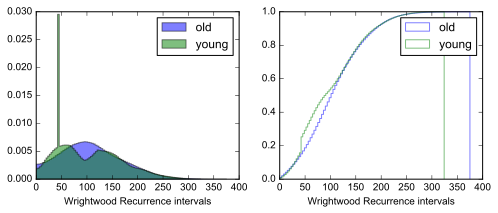

In [14]:
plt.figure(figsize=(8,3))
plt.subplot(121)

plt.hist(old_rec_ints.ravel(), bins=100, normed=True,
         alpha=0.5, histtype='stepfilled', label='old')
plt.hist(young_rec_ints.ravel(), bins=100, normed=True,
         alpha=0.5, histtype='stepfilled', label='young')
plt.legend()

plt.xlabel('Wrightwood Recurrence intervals')

plt.subplot(122)

plt.hist(old_rec_ints.ravel(), bins=100, normed=True, cumulative=True,
         alpha=0.5, histtype='step', label='old')
plt.hist(young_rec_ints.ravel(), bins=100, normed=True, cumulative=True,
         alpha=0.5, histtype='step', label='young')
plt.ylim([0,1])
plt.legend()

plt.xlabel('Wrightwood Recurrence intervals')
plt.show()

This is pretty interesting. It shows that the young series has a bimodal
recurrence interval, while the older one does not. This makes sense
given how the older time series looked more linear than the young one.
Nonetheless, their cumulative distributions look similar, and match quite
impressively through much of the range.

But in general, we see that there is a broad mode at ~100 years, which may
be shorter (up to less than a year) and as old as ~350 years. So there is
a fair amount of variability in the system.

The spike at just under 50 years has to do with the timing between the 
historical 1857 and 1812 earthquakes; because these two events are known 
to the year level with no uncertainty, there is no uncertainty in the time
between them, which produces a big spike in the PDF here.

However different the old and young recurrence intervals are, we're going
to just add them together and not worry here about what causes the differences.


In [15]:
wr_rec_ints = np.hstack([old_rec_ints.ravel(), 
                         young_rec_ints.ravel()])

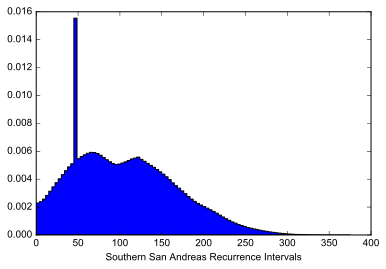

In [16]:
plt.hist(wr_rec_ints, bins=100, normed=True,
         histtype='stepfilled')
plt.xlabel('Southern San Andreas Recurrence Intervals')
plt.show()

Next, we need to extract the values from the histogram
so that we can make this into a function:

In [17]:
wr_int_probs, wr_int_vals = np.histogram(wr_rec_ints, 
                                         bins=100, normed=True)
wr_int_probs = np.append(0., wr_int_probs)

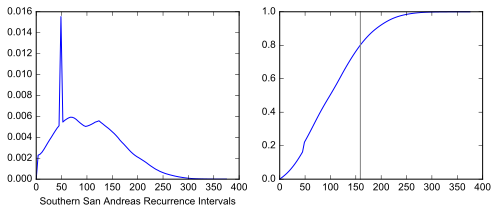

In [18]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(wr_int_vals, wr_int_probs)
plt.xlabel('Southern San Andreas Recurrence Intervals')

plt.subplot(122)
plt.plot(wr_int_vals, np.cumsum(wr_int_probs)/ np.sum(wr_int_probs))
plt.gca().axvline(2016-1857, color='grey')
plt.gca().set_ylim([0,1])

plt.show()

We now have a good, quantitative idea of how frequently earthquakes
occur on the southern San Andreas. The mean recurrence interval is 108
years; the maximum is almost 400 years. The current 159-year long duration
is well beyond the mean and the median (both about 100 years) but is
about the 80th percentile, meaning that one recurrence interval in five
is longer. 

This is consistent with the 5 in 26 recurrence intervals
in between the mean earthquake ages above being greater than 159 years.
The real difference is in the tails: The PDF we've made, incorporating
the uncertainty in the dates, allows for earthquakes very closely spaced
in time, or up to 375 years apart. These are not high-probability intervals,
but they're possible nonetheless.

## Time-dependent earthquake forecasting on the southern San Andreas

The motivation for this little study is the question of *What does
it mean when an earthquake is overdue?* We can answer this question to some
degree by using survival analysis, which will give us quantitative
expectations of how long we might keep waiting for the tardy event, given that
we've waited 159 years already.

This is a very similar situation to life expectancy. If a population has a
life expectancy at birth of (say) 65 years, but it also has a high
infant mortality rate, then the life expectancy of those who made it through
infancy alive will be considerably longer than 65 years: That 65 years is
an average of both very short lifetimes and longer ones, and the average of
the longer lifetimes will be higher than the average of the whole group.
So if we want to know the life expectancy of someone who is 5 years old,
we have to throw out the lifetime data from those who died in infancy.
And if we want to know how long a 66-year old woman will live, we'll
ignore the data from those that didn't make it past 65.

Survival analysis provides the tools to do this in an effective way. First,
we will define some simple functions that formalize the intuitive concepts
involved:

The first two are very basic, and we've already seen them:

$pdf(t)$ := the probability distribution function of $t$, the time (in years) between earthquakes.

$cdf(t)$ := the cumulative distribution function of $t$.

The next is called the *survival function* (or *reliability function*), and it
is the probability that a given lifetime (or recurrence interval) is longer 
than $t$. It's also the compliment of the $cdf$. We'll call it $S(t)$.

$S(t) = 1 - cdf(t)$

The survival function is interesting and useful in its own right, but we won't
dwell on it. Instead, we'll use it for calculating a few other, more topical
quantities. The first is the *hazard function* ($\lambda (t)$), which is the
rate of occurrence of events (earthquakes) at time $t$, given that an earthquake
has not occurred in $t$ years.

$\lambda(t) = pdf(t) \, / \,S(t)$

The second important use of $S(t)$ is in calculating the *mean value* of $t$, which
is the mean of $pdf(t)$, but also conveniently $\int_0^\infty S(t) dt$. The mean
value is often called the 'expected lifetime' and in our situation, is the average
recurrence interval.

Let's code these up and do some analysis:

In [19]:
def pdf(t):
    pdf_ = interp1d(wr_int_vals, wr_int_probs, kind='cubic',
                   bounds_error=False, fill_value=0.)
    return pdf_(t)


def cdf(t):
    cdf_ = interp1d(wr_int_vals, 
                    np.cumsum(wr_int_probs) / np.sum(wr_int_probs),
                    kind='cubic', bounds_error=False, fill_value=1.)
    return cdf_(t)


def S(t):
    return 1 - cdf(t)


def λ(t):
    return pdf(t) / S(t)


def mean_rec_interval(t):
    return trapz(S(t), t)

### Earthquake hazards each year

The earthquake hazard for the year 2016, i.e. the probability that
an earthquake will occur on the southern San Andreas this year, is:

In [20]:
λ(2016-1857)

0.020610501157809748

i.e. a 2% chance. This probability will increase basically every year, unless
an earthquake happens:

In [21]:
ts = np.arange(1,370) # vector of years since last event (starting from 0)

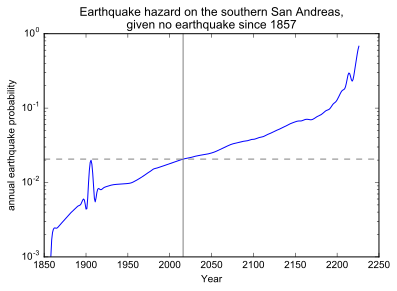

In [22]:
plt.plot(ts + 1857, λ(ts))
plt.gca().set_yscale('log')
plt.gca().axvline(2016, color='grey')
plt.gca().axhline(λ(2016-1857), color='grey', linestyle='--')

plt.title('Earthquake hazard on the southern San Andreas,\n'+
          'given no earthquake since 1857')
plt.xlabel('Year')
plt.ylabel('annual earthquake probability')

plt.ylim([1e-3, 1])

plt.show()

We are, as of this writing, at the grey line.

It's pretty obvious from this figure that the hazard on the
southern San Andreas will keep increasing until an earthquake
happens. This isn't the case for all faults or fault systems;
some faults show evidence for earthquake clusters, where there
is a high hazard in the years to decades following a significant
event, which drops off after that. These clusters may be caused
by triggering of subsequent earthquakes due to stress changes
induced by the first one. Volumes of crust with many
faults may have an essentially uniform or time-invariant hazard,
which is indicative of an exponential recurrence
interval distribution.

The slight oscillations at the far end of the time series are caused
by the histogram binning of very sparse samples at the long tail
of the $pdf(t)$; in reality this should increase smoothly.
Similarly, the little oscillations near the 50 year spike are from
the cubic spline interpolation.

### Expected time until the next earthquake

*It's been 159 years since the last earthquake; when will the next one happen?*

This is the big question. We're not going to try to issue a hyper-precise *prediction*,
but we can issue a probabilistic *forecast* (for a more in-depth discussion of the difference, go [here](http://www.geolsoc.org.uk/earthquake-briefing).)

We can use a function based on the survival function $S(t)$, called the *conditional survival
function* (or the 'remaining lifetime' function in demographic studies) to help with the
forecasting. The conditional survival function describes the probability of a lifetime $t$
given that $t > t_e$, where $t_e$ is the elapsed time (the time since the last earthquake).

The conditional survival function $S_{cond}(t, t_e)$ is derived from $S(t)$:

$S_{cond}(t, t_e) = S(t) \, / \, S(t_e)$ (where $t > t_e$).

For our purposes, the conditional survivor function is again most useful in providing
us with the conditional recurrence interval PDF, i.e. the PDF of recurrence intervals
longer than the $t_e$. We can get this by working backwards:

$pdf_{cond}(t, t_e) = -d\, S_{cond}(t, t_e) \,/ \, dt $

We can also take the mean recurrence interval calculation (the integral of $S(t)$),
and substitute $S_{cond}$ for $S$, giving us the *mean time remaining* (this is often
called the 'mean remaining lifetime' in demographics). It is, simply, the mean number
of years left until the next earthquake.

Mean time remaining = $\int_{t_e}^\infty S_{cond}(t, t_e) dt$

OK, let's code this up so we can see the results.

In [23]:
def mas(t,t_e):
    return t[t>t_e]


def menos(t,t_e):
    return t[t<=t_e]


def S_cond(t, t_e, return_past=True):
    
    t_ = mas(t, t_e)
    _t = menos(t, t_e)
    
    S_conds = S(t_) / S(t_e)
    
    if return_past == True:
        return np.hstack([np.ones(len(_t)), S_conds])
    else:
        return S_conds
    
    
def pdf_cond(t, t_e):
    
    diffs = np.diff( 1 - S_cond(t, t_e))
    
    return np.append(0., diffs)

    
def mean_time_remaining(t,t_e):
    
    t_ = mas(t, t_e)
    return trapz(S_cond(t_, t_e, return_past=False), t_)

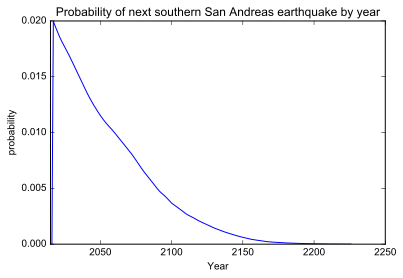

In [24]:
plt.plot(ts + 1857, pdf_cond(ts, 159))
plt.xlim([2015, 2250])
plt.ylim([0, 0.02])

plt.xlabel('Year')
plt.ylabel('probability')
plt.title('Probability of next southern San Andreas earthquake by year')
plt.show()

Ouch! The highest probability year for the next earthquake is 2016!
(Note again that this probability is ~0.02, as we calculated above).

This is consistent with the general observation that the PDF for
recurrence intervals drops monotonically after ~130 years; it is
more likely that the recurrence interval we're living in now is 159
years long, rather than 160, 180, etc.

However, even though the peak of this PDF is at 2016, that peak
is only 2%, and there is still quite a bit left. This is where the
*mean time remaining* calculation comes in: it gives us the
average time left in the earthquake cycle, given that it's been
159 years so far.

In [25]:
mean_time_remaining(ts, 159)

38.207254921781896

About 40 years, or about 2055 for the average (or 'expected') next
earthquake. So it's possible that it will be a few years, but is still
within many of our lifetimes. Again, it's important to remember that this
is an average, not a single number, and that the probability distribution
shown in the last figure is a much better guide to what may happen. So,
you know, don't sue me if it's tomorrow, or in 2020.

(This is the end of the post here. For those who want to read
or perform the recurrence interval calculations, read on.)

## Appendix: Calculating earthquake recurrence probabilities

We want to know how frequently earthquakes occur on the southern San Andreas;
this frequency is a variable, the 'earthquake recurrence interval'. Because of both the
uncertainty in the timing of individual earthquakes and the real variation in
the recurrence, the recurrence interval will be a distribution.

I'll estimate this distribution through a Monte Carlo analysis, in which I generate
many synthetic earthquake time series from the data; the variation in these
time series represents the uncertainty in the earthquake times. Then, I will
calculate the earthquake recurrence distribution from the synthetic data, and
use the results to describe the future probabilities of earthquake timing on the
southern San Andreas fault.

I'll split the earthquake time series up into 'old' and 'young' series, calculate
their recurrence intervals independently, and then add them together in order
to proceed with the analyisis.

In [5]:
w_young = wrightwood_eqs[wrightwood_eqs.age_mean > 0]
w_old = wrightwood_eqs[wrightwood_eqs.age_mean < 0]

Let's see how much the mean (expected) recurrence interval is
different between the two series:

In [6]:
np.mean(np.diff(w_young.age_mean)), np.mean(np.diff(w_old.age_mean)), 

(101.76923076923077, 108.61538461538461)

OK, that's not so different, which is reassuring.

### Making earthquake timing probabilities

The next step is to take the data (given as 5%, mean, and 95% values) and make them
into probability distributions so that we can make probability distributions of
the recurrence intervals, which are the durations in between each earthquake.

The PDFs for the earthquake times themselves are 'arbitrary', or not Gaussian, uniform,
etc. They're the result of a combination of several types of constraints. Some analytical
radiocarbon dates will be present for certain layers, producing Gaussian ages, then
there will be logical relationships based on those: For example, an earthquake may be older than 500 +/- 30 years, because sediment of that age is not disturbed, but younger than 635 +/- 20 years because sediment of that age is cut by the faults (I'm making up numbers here but this is the gist of it).

However, I don't have those PDFs, I just have the 5th and 95th percentiles and the mean,
because that's what's reported in the data tables. So I'm just going to simplify things by
saying that the 5 and 95 percentiles are the maximum and minimum values. I'll then use some basic equations for triangular distributions to calculate the peak of the triangular distribution, and then define the distribution in order to sample from it (the equations can be found [here](https://learnandteachstatistics.files.wordpress.com/2013/07/notes-on-triangle-distributions.pdf)).

Here are a couple Python functions that I'll use to do that calculation:

In [7]:
def make_eq_pdf(age_min, age_mean, age_max):
    
    age_break = get_age_break(age_min, age_max, age_mean)
    
    xs = np.array([age_min, age_break, age_max])
    
    return xs, triangular_pdf(xs, *xs)
    
    
def triangular_pdf(x, age_min, age_break, age_max):
    
    x = np.asarray(x, dtype=float)
    
    p = lambda x: np.piecewise(x, [x <= age_min, 
                                   (age_min < x) & (x <= age_break),
                                   (age_break < x) & (x <= age_max),
                                   x > age_max],
        [0,
         lambda x: 2 * (x - age_min) / ((age_max - age_min) * (age_break - age_min)),
         lambda x: 2 * (age_max - x) / ((age_max - age_min) * (age_max - age_break)),
         0])
    
    return p(x)


def get_age_break(age_min, age_max, age_mean):
     return 3 * age_mean - age_min - age_max

Let's check it out:

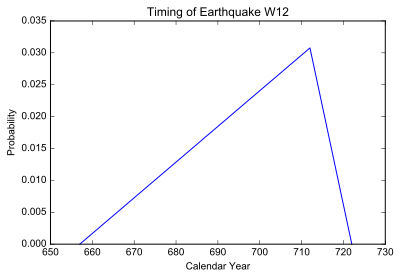

In [8]:
plt.plot(*make_eq_pdf(*wrightwood_eqs.ix[16, ['age_5', 'age_mean', 'age_95']]))
plt.xlabel('Calendar Year')
plt.ylabel('Probability')

plt.title('Timing of Earthquake {}'.format(wrightwood_eqs.ix[16, 'eq']))

plt.show()

Now, I can make the PDFs for each, and then sample those PDFs using
an [Inverse Transform Sampling][its] algorithm. This algorithm
can sample an arbitrary PDF by computing the Cumulative Distribution
Function (CDF) of the PDF, then inverting the CDF, and using
uniformly-random samples from [0,1) as arguments to the inverse CDF.
The outputs of the function will be samples drawn from the original
PDF.

(Inverse transform sampling is one of the most useful techniques
I've come across in years of doing statistical geoscience; the
ability to sample from any (bounded) PDF is extremely enabling
for all sorts of problems, especially in empirical science where
we have lots of nonstandard PDFs. You can lose a lot of accuracy
by forcing your data into some standard PDF form, and this allows
for a Bayesian posterior distribution to be used as the prior
for the next problem.)

[its]: https://en.wikipedia.org/wiki/Inverse_transform_sampling

In [9]:
def make_pdf(vals, probs, n_interp=1000):

    val_min = np.min(vals)
    val_max = np.max(vals)
    
    # if the PDF is just a point (no uncertainty)
    if val_min == val_max: 
        return val_min, 1.
    
    # if not...
    else:
        pdf_range = np.linspace(val_min, val_max, n_interp)

        pmf = interp1d(vals, probs)
        pmf_samples = pmf(pdf_range)
        pdf_probs = pmf_samples / np.sum(pmf_samples) # normalize

    return pdf_range, pdf_probs


def make_cdf(pdf_range, pdf_probs):
    return (pdf_range, np.cumsum(pdf_probs))


def inverse_transform_sample(vals, probs, n_samps, n_interp=1000):
    
    pdf_range, pdf_probs = make_pdf(vals, probs, n_interp)
    cdf_range, cdf_probs = make_cdf(pdf_range, pdf_probs)

    if len(cdf_probs) == 1:
        return np.ones(n_samps) * pdf_range
    
    else:
        cdf_interp = interp1d(cdf_probs, cdf_range, bounds_error=False,
                              fill_value=0.)
        samps = np.random.rand(n_samps)

        return cdf_interp(samps)
    

def sample_eq_pdf(row, n_samps):
    eq_vals, eq_probs = make_eq_pdf(row['age_5'], row['age_mean'], 
                                    row['age_95'])
    
    return inverse_transform_sample(eq_vals, eq_probs, n_samps)

Lets see how it works by making a PDF and sampling it:

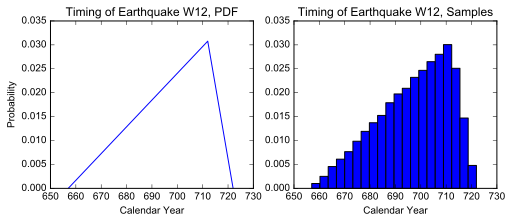

In [10]:
plt.figure(figsize=(8,3))
plt.subplot(121)

plt.plot(*make_eq_pdf(*wrightwood_eqs.ix[16, ['age_5', 'age_mean', 'age_95']]))
plt.xlabel('Calendar Year')
plt.ylabel('Probability')
plt.title('Timing of Earthquake {}, PDF'.format(wrightwood_eqs.ix[16, 'eq']))

plt.subplot(122)
plt.hist(sample_eq_pdf(wrightwood_eqs.ix[16], 50000), bins=20, normed=True) 
plt.xlabel('Calendar Year')
plt.title('Timing of Earthquake {}, Samples'.format(wrightwood_eqs.ix[16, 'eq']))

plt.show()

And we see that they match up pretty well.

### Earthquake recurrence from synthetic earthquake time series

Now that I can sample from the individual earthquake timing PDFs,
I can generate synthetic earthquake time series. Each time series
represents one sample from each of the earthquakes.

Then, I will sort the time series<sup>[1](#fn_1)</sup> so that the
ages are increasing, and then calculate the time in between each
event using the mathematical technique of subtraction.

(I am doing these calculations independently for both the young
and old series, so that there is not an erroneous 2000-year gap;
the recurrence intervals will then be added together following
the calculations).




<a name="fn_1">1</a>: The geologic data used to make the paleoseismic
series here may have information on the relative timing of events, if
for example strata deformed during one event is not deformed by the previous 
event (meaning that the strata are younger than the earlier event) even if 
the geochronologic ages overlap. This is quite common, and maybe even
more likely than not. But I don't really know for which events this is
true, so I will simply treat each event as having timing that is
*independent* of the other events, which makes the calculations
easier.

In [11]:
# Make EQ time series

n_samples = int(1e6)

# sample each earthquake n_samples times, then
# transpose so each row is an earthquake time series
old_times = np.array([sample_eq_pdf(eq[1], n_samples) 
                      for eq in w_old.iterrows()]).T

young_times = np.array([sample_eq_pdf(eq[1], n_samples) 
                        for eq in w_young.iterrows()]).T

In [12]:
def recurrence_intervals(times):
    # sort each row, calculate the time differences
    return np.diff(np.sort(times, axis=1), axis=1)

In [13]:
old_rec_ints = recurrence_intervals(old_times)
young_rec_ints = recurrence_intervals(young_times)